In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [2]:
# trialregs_dot = 0
resfile = helpers.resultsdir + '/meg_sequential_201703011624.h5'

# trialregs_dot = 5
# resfile = helpers.resultsdir + '/meg_sequential_201703011927.h5'

evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [3]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax'):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)
            
def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif model == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');

# Second level analysis

In [4]:
second_level = pd.read_hdf(resfile, 'second_level')
perms = second_level.index.levels[0]

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))
tvals['accev'] = -tvals['accev']

### describe genuine regressors

In [5]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accsur_pca,dot_x,dot_y,entropy,intercept,response,trial_time
count,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,-0.000045,0.000932,0.000133,-0.000046,0.000044,-0.000024,-0.001080,-0.001117,0.000233,0.001974
std,0.009791,0.006491,0.031574,0.004593,0.024072,0.014689,0.009797,0.038345,0.011883,0.007737
min,-0.040095,-0.032475,-0.108537,-0.015437,-0.084566,-0.079409,-0.038213,-0.129775,-0.036813,-0.030284
25%,-0.005947,-0.003054,-0.014990,-0.002857,-0.011376,-0.004744,-0.007183,-0.022419,-0.006509,-0.002489
50%,-0.000339,0.001038,0.004682,0.000009,-0.000584,0.000440,-0.001784,-0.003366,-0.001212,0.001936
75%,0.005717,0.005262,0.019172,0.002799,0.007607,0.005031,0.004673,0.020698,0.004808,0.006823
max,0.055947,0.035613,0.094337,0.023159,0.115497,0.069896,0.031561,0.156807,0.068880,0.026418


### describe regressors of first permutation

In [6]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x,abs_dot_y,accev,accsur_pca,dot_x,dot_y,entropy,intercept,response,trial_time
count,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000
mean,0.000236,-0.000034,0.000033,0.000028,0.000103,-0.000088,-0.000227,-0.001136,-0.000090,-0.000212
std,0.007936,0.004394,0.004316,0.003956,0.004080,0.004383,0.005696,0.037789,0.003931,0.003089
min,-0.031258,-0.014118,-0.014079,-0.012811,-0.016922,-0.013792,-0.018446,-0.129239,-0.011808,-0.011059
25%,-0.004850,-0.002974,-0.002740,-0.002694,-0.002484,-0.003100,-0.004310,-0.022908,-0.002817,-0.002389
50%,0.000236,0.000021,0.000029,0.000076,0.000307,-0.000104,-0.000239,-0.003296,-0.000154,-0.000090
75%,0.005279,0.002907,0.002689,0.002764,0.002907,0.002744,0.003601,0.020621,0.002625,0.002047
max,0.032327,0.014798,0.020212,0.014647,0.016355,0.017343,0.018899,0.158998,0.013952,0.010228


## Show evolution of max (across channels) through the trial

<IPython.core.display.Javascript object>


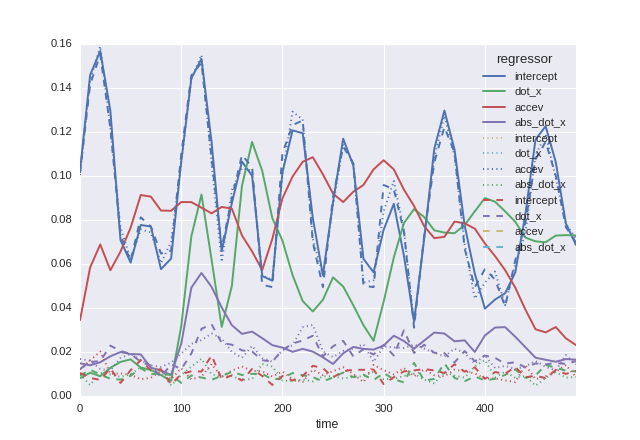

In [7]:
reg = ['intercept', 'dot_x', 'accev', 'abs_dot_x']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmax')

<IPython.core.display.Javascript object>


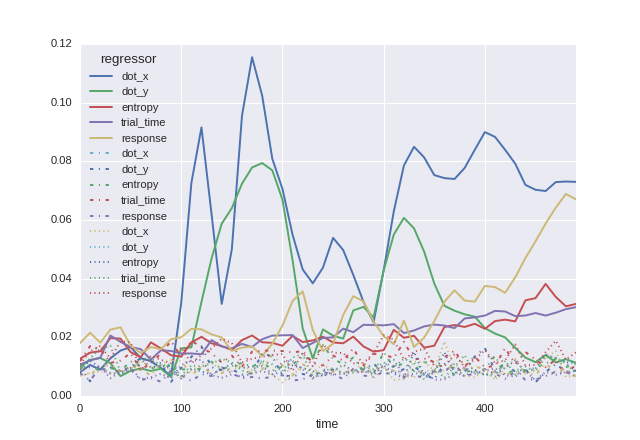

In [8]:
plot_minmax_regressors(second_level, ['dot_x', 'dot_y', 'entropy', 'trial_time', 'response'], 
                       measure, nperm=2, mode='absmax')

## Export for Stefan

In [9]:
from scipy.io import savemat
dot_x = second_level.loc[(0, slice(None), slice(None)), ('mean', 'dot_x')]
dot_x = dot_x.reset_index(level='channel').pivot(columns='channel')
savemat('dot_x.mat', {'data': dot_x.values, 'channels': dot_x.columns.levels[2].values, 
                      'times': dot_x.index.levels[1].values})

## Investigate topography

<IPython.core.display.Javascript object>


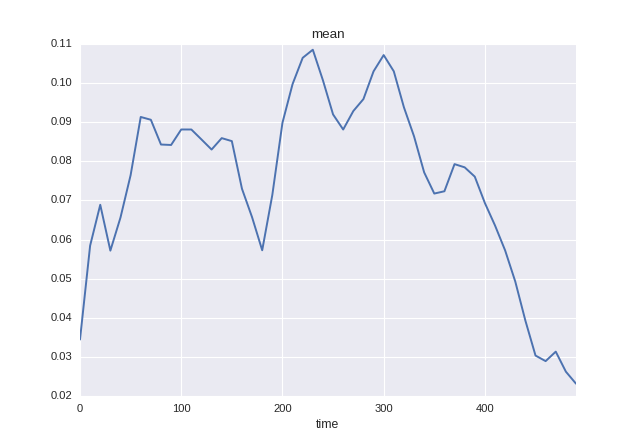

<IPython.core.display.Javascript object>


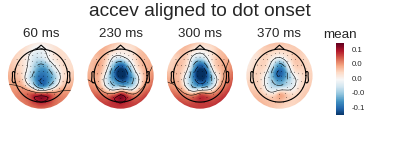

In [10]:
show_topology_at_peaks(second_level, 'accev', 'mean', order=3)

<IPython.core.display.Javascript object>


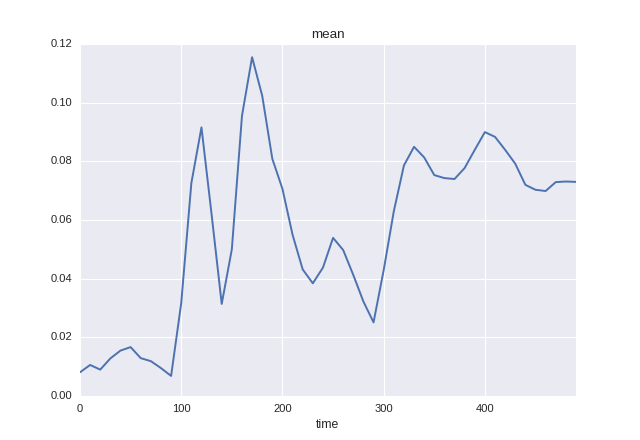

<IPython.core.display.Javascript object>


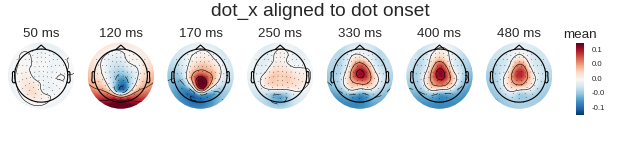

In [11]:
show_topology_at_peaks(second_level, 'dot_x', 'mean', order=3)

<IPython.core.display.Javascript object>


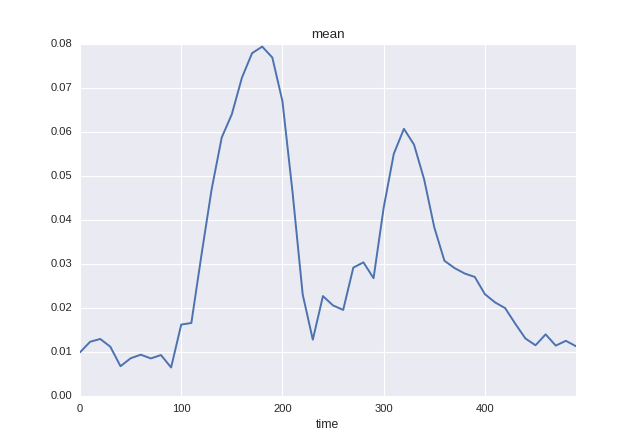

<IPython.core.display.Javascript object>


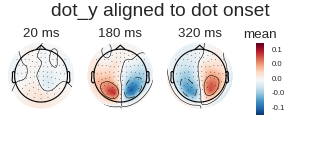

In [12]:
show_topology_at_peaks(second_level, 'dot_y', 'mean')

<IPython.core.display.Javascript object>


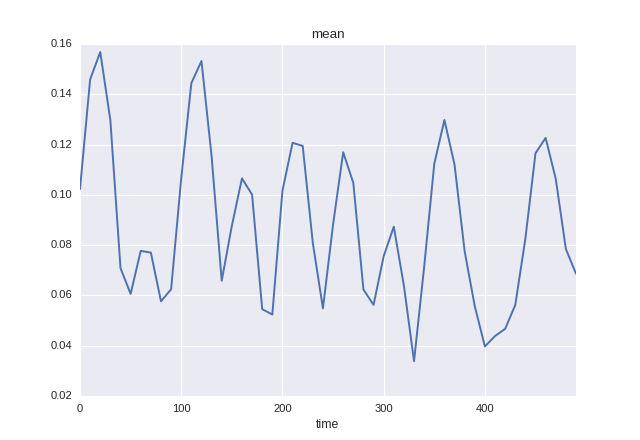

<IPython.core.display.Javascript object>


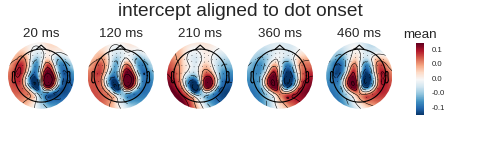

In [13]:
show_topology_at_peaks(second_level, 'intercept', 'mean')

<IPython.core.display.Javascript object>


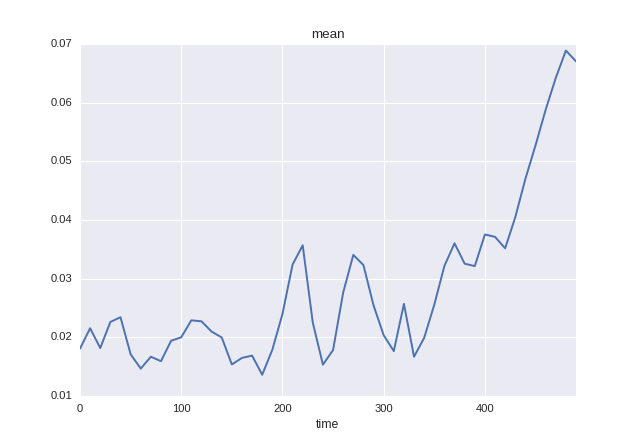

<IPython.core.display.Javascript object>


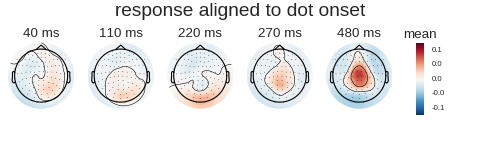

In [14]:
show_topology_at_peaks(second_level, 'response', 'mean')

# Check single subject results

In [15]:
first_level_diagnostics = pd.read_hdf(resfile, 'first_level_diagnostics')
first_level = pd.read_hdf(resfile, 'first_level')

<IPython.core.display.Javascript object>


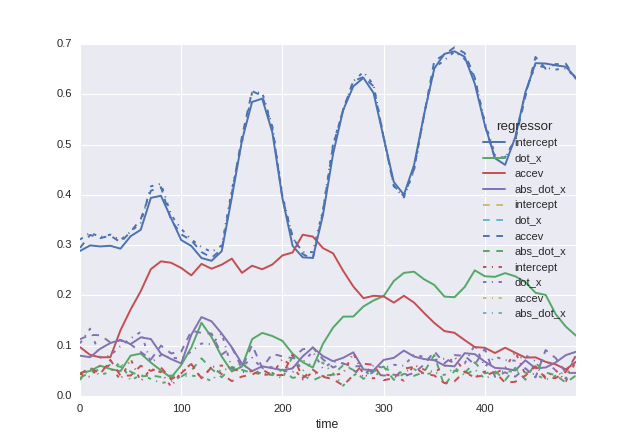

<IPython.core.display.Javascript object>


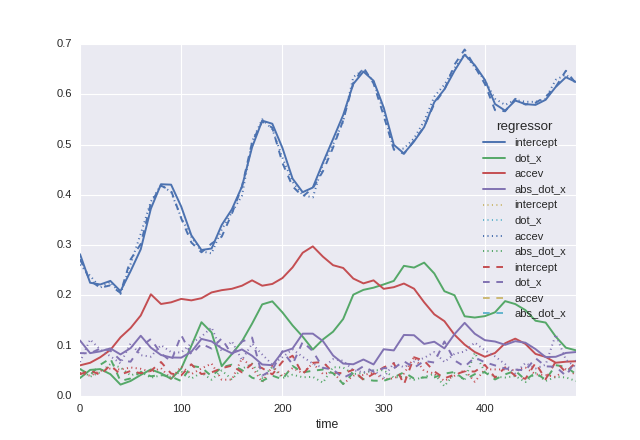

<IPython.core.display.Javascript object>


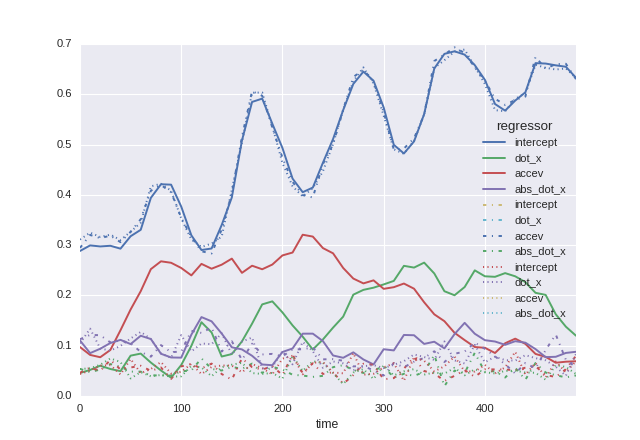

In [16]:
sub = 4
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='max')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='min')
plot_minmax_regressors(first_level.xs(sub, level='subject', axis=1), 
                       reg, 'beta', nperm=2, mode='absmax')

## Determine relative 'power' of 20 and 60 ms peaks in intercept

In [17]:
times = first_level.index.levels[2]

# determine mean in 100 ms bins
for tbin in range(int(np.ceil(times[-1] / 100))):
    tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
    
    binmean = first_level.loc[(0, slice(None), tbin_times), 
        (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()
    
# first 200 ms


In [18]:
tbin=1
times = first_level.index.levels[2]
tbin_times = times[(times >= tbin * 100) & (times < (tbin+1) * 100)]
first_level.loc[(0, slice(None), tbin_times), (slice(None), 'beta', 'intercept')].abs().max(level='time').mean()

subject  measure  regressor
2        beta     intercept    0.389247
3        beta     intercept    0.264310
4        beta     intercept    0.424077
5        beta     intercept    0.432001
6        beta     intercept    0.558149
7        beta     intercept    0.336534
8        beta     intercept    0.398896
9        beta     intercept    0.399745
10       beta     intercept    0.294193
11       beta     intercept    0.296134
12       beta     intercept    0.620539
13       beta     intercept    0.384772
15       beta     intercept    0.426321
16       beta     intercept    0.557392
17       beta     intercept    0.504056
18       beta     intercept    0.559385
19       beta     intercept    0.409016
20       beta     intercept    0.470337
21       beta     intercept    0.324355
22       beta     intercept    0.394971
23       beta     intercept    0.330052
24       beta     intercept    0.417385
25       beta     intercept    0.604494
26       beta     intercept    0.555887
27       bet